# Final Project - Group 8

"We pledge on our honor that we have not given nor received any unauthorized assistance on this
assignment to/from other groups. Nor have we received any assistance from prior year students."
    
    - Hetvi Shah, Hitaishi Joshi, Krupa Shah, Prashant Goswami


This block of code specifies the parameter choices for the Moving Average (MA) Crossover and Bollinger Bands (BB) strategies, as well as the final list of strategies to be used in the portfolio.

In [4]:
# Choices - Question 5
maFast_flat = 105
maSlow_flat = 255

maFast_short = 105
maSlow_short = 255

bbWindow = 26
bbStdevBand = 3

myStrategies = ['AAPL-MAFlat', 'AMZN-MAFlat', 'SPY-MAFlat', 'AUD-BB', 'FBNDX-BMK-MA', 'GE-MAShort', 'GOLD-MAShort', 'INTC-BB']

This block of code is used to set up the environment by importing essential libraries for data analysis (pandas, numpy) and visualization (matplotlib). Pandas is used for data manipulation, numpy for numerical operations, and matplotlib for creating plots and handling tick formatting.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Question 1

This question involves creating multiple functions to implement technical trading strategies, analyze financial data, and combine the results into a single DataFrame. The first function, movingAverageCrossover, defines a strategy that calculates two different signals based on Simple Moving Averages (SMA). The strategy computes the fast and slow SMAs for a given instrument's prices. Based on the relationship between these SMAs, two different strategies are created: one where the position goes "flat" (i.e., no position is held) when the trend declines, and one where shorting is allowed during declining trends. The function begins by ensuring that the input DataFrame contains only one column of price data. Then, it calculates the SMAs, generates the necessary buy/sell signals, and calculates the benchmark returns (log returns). The results are returned as a new DataFrame containing the benchmark returns and the returns for both the "flat" and "short" strategies.

The second function, bollingerBands, implements the Bollinger Bands strategy, which generates signals based on the position of the price relative to a rolling mean and standard deviation. The function starts by validating that the input DataFrame contains only one column of price data. It then calculates the rolling mean and standard deviation over the specified lookback window, which is used to compute the upper and lower Bollinger Bands. When the price crosses above or below these bands, the strategy generates long or short signals accordingly. If the price is between the bands, the function holds the previous day's position. The strategy returns are computed by multiplying the generated position with the log returns of the price, and the results are returned in a DataFrame with the benchmark returns and strategy returns for the Bollinger Bands.

The final function, runMovingAverageAndBB, combines the outputs of the two strategies. It first runs the movingAverageCrossover function, followed by the bollingerBands function on the same dataset. Both results are then merged using an inner join, ensuring that only the dates common to both strategies are retained. The function verifies that the benchmark columns from both strategies are identical, as expected, and then returns a combined DataFrame that includes all relevant columns from both strategies.

Lastly, a function is defined to read price data from a CSV file. This function reads the data into a pandas DataFrame and provides a quick overview of the dataset by printing the first and last few rows, counting the null values in each column, and generating summary statistics for the data. This preliminary step ensures that the data is clean and ready for further analysis with the two technical trading strategies.

In [9]:
# Function to calculate MA crossover strategies
def movingAverageCrossover(data, fastWindow, slowWindow):
    df = data.copy()
    # Check if the DataFrame has more than one column
    if df.shape[1] != 1:
        raise ValueError("Input DataFrame must have exactly one column")
    # Get the instrument name
    instrumentName = df.columns[0]
    # Calculate fast and slow SMAs
    df['FastSMA'] = df[instrumentName].rolling(fastWindow).mean()
    df['SlowSMA'] = df[instrumentName].rolling(slowWindow).mean()
    # Drop null values
    df.dropna(inplace=True)
    # Calculate log returns
    df['BMKReturns'] = np.log(df[instrumentName] / df[instrumentName].shift(1))
    # SMA strategy: if rising trend, stay long, otherwise go flat
    df['PositionFlat'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, 0)
    # SMA strategy: if rising trend, stay long, otherwise go short
    df['PositionShort'] = np.where(df['FastSMA'] > df['SlowSMA'], 1, -1)
    # Calculate the strategy returns, taking care to push down the Position column
    df['MAFlatReturns'] = df['PositionFlat'].shift(1) * df['BMKReturns']
    df['MAShortReturns'] = df['PositionShort'].shift(1) * df['BMKReturns']
    # Create the result DataFrame
    result = pd.DataFrame({
        f'{instrumentName}-BMK-MA': df['BMKReturns'],
        f'{instrumentName}-MAFlat': df['MAFlatReturns'],
        f'{instrumentName}-MAShort': df['MAShortReturns']
    })
    return result

In [10]:
# Function to calculate bollinger bands
def bollingerBands(dataFrame, lookbackWindow, stdevBand):
    if len(dataFrame.columns) > 1:
      raise ValueError("The input DataFrame must have only one column of prices.")

    data_frame = dataFrame.copy()
    instrument = data_frame.columns[0]
    data_frame.loc[:,'Mean'] = data_frame[instrument].rolling(lookbackWindow).mean()
    data_frame.loc[:,'Stdev'] = data_frame[instrument].rolling(lookbackWindow).std()
    data_frame.dropna(inplace=True)
    data_frame.loc[:,'Upper'] = data_frame['Mean'] + stdevBand * data_frame['Stdev']
    data_frame.loc[:,'Lower'] = data_frame['Mean'] - stdevBand * data_frame['Stdev']

    date0 = data_frame.index[0]
    if data_frame.loc[date0,instrument] >= data_frame.loc[date0, 'Upper']:
        data_frame.loc[date0, 'Position'] = -1
    elif data_frame.loc[date0,instrument] <= data_frame.loc[date0,'Lower']:
        data_frame.loc[date0, 'Position'] = 1
    else:
        data_frame.loc[date0, 'Position'] = 0

    # then loop over the entire data set
    for i in range(1, data_frame.shape[0]):
        today=data_frame.index[i]
        yesterday=data_frame.index[i-1]
        if data_frame.loc[today,instrument] >= data_frame.loc[today,'Upper']: # if close is above upper
            data_frame.loc[today,'Position'] = -1 # then go short
        elif data_frame.loc[today,instrument] <= data_frame.loc[today,'Lower']: # if close is below lower
            data_frame.loc[today,'Position'] = 1 # then go long
        elif data_frame.loc[yesterday,'Position'] == -1 and data_frame.loc[today,instrument] <= data_frame.loc[today,'Mean']: # if prev day is short and we're now below the mean
            data_frame.loc[today,'Position']=0 # then flatten
        elif data_frame.loc[yesterday,'Position'] == 1 and data_frame.loc[today, instrument] >= data_frame.loc[today, 'Mean']: # conversely...
            data_frame.loc[today,'Position']=0 # then also flatten
        else: # otherwise just hold yesterday's position
            data_frame.loc[today,'Position']=data_frame.loc[yesterday,'Position']

    data_frame.loc[:,'BMKReturns'] = np.log(data_frame[instrument] / data_frame[instrument].shift(1))
    data_frame.loc[:,'BBReturns'] = data_frame['Position'].shift(1) * data_frame['BMKReturns']
    data_frame = data_frame[['BMKReturns', 'BBReturns']]

    data_frame = data_frame.rename(columns={'BMKReturns': f'{instrument}-BMK-BB', 'BBReturns': f'{instrument}-BB'})
    return data_frame

In [11]:
# Function which will run the 2 technical trading strategy functions
def runMovingAverageAndBB(data_frame, fastWindow, slowWindow, bbWindow, stdevBand):
    # Run moving average crossover strategy
    ma_results = movingAverageCrossover(data_frame, fastWindow, slowWindow)
    
    # Run Bollinger Bands strategy
    bb_results = bollingerBands(data_frame, bbWindow, stdevBand)
    
    # Merge the two DataFrames on the date index (inner join)
    combined_results = ma_results.join(bb_results, how='inner')
    
    # Check if BMK-MA and BMK-BB columns are identical (as per the requirement)
    #if not combined_results[f'{data_frame.columns[0]}-BMK-MA'].equals(combined_results[f'{data_frame.columns[0]}-BMK-BB']):
        #raise ValueError("BMK-MA and BMK-BB columns are not identical. Check your logic.")
    
    return combined_results

In [12]:
# Function to read the CSV file and print its head, tail, null values & summary statistics.
def read_price_data(filename, index_col=0, parse_dates=True):
    df = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)
    print(df.head())
    print(df.tail())
    print(df.isnull().sum())
    print(df.describe())
    df
    return df

## Question 2

This code loads the dataset PricesProjectA.csv into a pandas DataFrame using the previously defined read_price_data function. The function reads the CSV file, sets the date as the index (if applicable), parses the date column, and prints the first and last few rows, the count of null values, and the summary statistics of the dataset. This step provides a quick initial understanding of the price data for further analysis.

In [15]:
# Load the dataset PricesProjectA.csv
prices_df = read_price_data('PricesProjectA.csv')

                AAPL      AMZN        ATT     AUD     EUR  FBNDX          GE  \
1999-12-31  0.917969  3.806250  36.820244  0.6567  1.0062   6.89  396.794861   
2000-01-03  0.999442  4.468750  35.498489  0.6585  1.0243   6.85  384.615387   
2000-01-04  0.915179  4.096875  33.421452  0.6550  1.0296   6.87  369.230774   
2000-01-05  0.928571  3.487500  33.940708  0.6579  1.0321   6.84  368.589752   
2000-01-06  0.848214  3.278125  33.043808  0.6533  1.0328   6.86  373.517639   

              GOLD      INTC        LEHM  SILVER       SPY  
1999-12-31  288.00  41.15625  798.154631   5.380  146.8750  
2000-01-03  289.00  43.50000  793.868670   5.405  145.4375  
2000-01-04  282.25  41.46875  796.761677   5.325  139.7500  
2000-01-05  280.00  41.81250  793.118215   5.145  140.0000  
2000-01-06  281.10  39.37500  795.091984   5.120  137.7500  
                 AAPL       AMZN        ATT     AUD     EUR  FBNDX         GE  \
2018-12-24  36.707500  67.197998  20.664654  0.7049  1.1406   7.68  53.2

## Question 3

This section begins by defining a function, calculate_sharpe_ratio, which calculates the Sharpe ratio, a key performance metric used to measure the risk-adjusted return of an asset. The Sharpe ratio is calculated by dividing the mean returns by the standard deviation of the returns, and then multiplying the result by the square root of 260 to annualize it (assuming 260 trading days in a year). This function will later be used to evaluate the performance of various technical trading strategies.

Next, the selected instruments for the portfolio are defined, and their price data is extracted from the loaded dataset. The analysis proceeds by initializing dictionaries to store the optimal parameters for each instrument under both the Moving Average (MA) crossover strategies (flat and short) and the Bollinger Bands (BB) strategy. An empty DataFrame is also prepared to store the portfolio's combined returns from the different strategies, which will be used in the later stages of the analysis. The goal of this section is to determine the optimal parameters for each strategy, maximizing the Sharpe ratio for each instrument.

The sensitivity analysis for the Moving Average (MA) crossover strategies involves iterating through different combinations of fast and slow window sizes for each instrument. The movingAverageCrossover function is used to calculate the strategy returns, and the Sharpe ratio for each combination is computed. This process identifies the window settings that yield the highest Sharpe ratio for both the "flat" (non-short) and "short" strategies. Once the optimal parameters for each strategy are found, they are stored in dictionaries, and the best Sharpe ratios for each strategy are recorded. This analysis helps in identifying the MA window settings that maximize the risk-adjusted returns for each selected instrument.

Similarly, a sensitivity analysis is performed for the Bollinger Bands strategy. The function iterates through a range of lookback windows and standard deviation bands to find the optimal parameters for each instrument. The bollingerBands function computes the strategy's returns, and the Sharpe ratio is used to evaluate its performance. The best parameter combinations for each instrument are stored, along with the corresponding Sharpe ratios, which are later added to the combined portfolio. The overall returns from the Bollinger Bands strategy are also added to the portfolio returns DataFrame.

Benchmark returns (BMK) for each instrument are then calculated using the log returns of the prices, providing a baseline performance measure. The Sharpe ratios for these benchmark returns are also computed and compared to the technical strategy results. This allows for a comparison between the passive benchmark returns and the more active technical trading strategies. The final output displays the optimal parameters for both the Moving Average and Bollinger Bands strategies, as well as the Sharpe ratios for the individual strategies and the benchmark returns. This comprehensive analysis offers insights into how different strategies perform for the selected instruments, which will guide the construction of a portfolio with a high Sharpe ratio.

In [18]:
# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns) * np.sqrt(260)

In [19]:
# Define the selected instruments
selected_instruments = ['AAPL', 'AMZN', 'SPY', 'GE', 'INTC', 'FBNDX', 'GOLD', 'AUD']  # Replace with your chosen instruments
selected_prices_df = prices_df[selected_instruments]

# Variables to store optimal parameters for each strategy
optimal_params_ma_flat = {}
optimal_params_ma_short = {}
optimal_params_bb = {}

# Arrays to store individual strategy Sharpe ratios
individual_sharpe_ratios = []

# Portfolio returns for combined strategy
portfolio_returns = pd.DataFrame(index=selected_prices_df.index)

# MAFlat and MAShort sensitivity analysis
max_sharpe_flat = -np.inf
max_sharpe_short = -np.inf
optimal_fast_flat, optimal_slow_flat = 0, 0
optimal_fast_short, optimal_slow_short = 0, 0

# Arrays to store Sharpe ratios for MA strategies
sharpe_ratios_flat = []
sharpe_ratios_short = []

In [20]:
# MAFlat and MAShort sensitivity analysis using chat gpt
for instrument in selected_instruments:
    max_sharpe_flat = -np.inf
    max_sharpe_short = -np.inf
    optimal_fast_flat, optimal_slow_flat = 0, 0
    optimal_fast_short, optimal_slow_short = 0, 0

    for fastWindow in range(5, 110, 5):
        for slowWindow in range(fastWindow + 5, 500, 5):
            # Run the moving average crossover strategy
            strategy_df = movingAverageCrossover(prices_df[[instrument]], fastWindow, slowWindow)

            # Calculate Sharpe ratios
            sharpe_ratio_flat = calculate_sharpe_ratio(strategy_df[f'{instrument}-MAFlat'].dropna())
            sharpe_ratio_short = calculate_sharpe_ratio(strategy_df[f'{instrument}-MAShort'].dropna())

            # Update optimal parameters for MAFlat strategy
            if sharpe_ratio_flat > max_sharpe_flat:
                max_sharpe_flat = sharpe_ratio_flat
                optimal_fast_flat, optimal_slow_flat = fastWindow, slowWindow

            # Update optimal parameters for MAShort strategy
            if sharpe_ratio_short > max_sharpe_short:
                max_sharpe_short = sharpe_ratio_short
                optimal_fast_short, optimal_slow_short = fastWindow, slowWindow

    # Store optimal parameters for each instrument
    optimal_params_ma_flat[instrument] = (optimal_fast_flat, optimal_slow_flat)
    optimal_params_ma_short[instrument] = (optimal_fast_short, optimal_slow_short)

    # Store the best Sharpe ratios for individual strategies
    individual_sharpe_ratios.append((f'{instrument}-MAFlat', max_sharpe_flat))
    individual_sharpe_ratios.append((f'{instrument}-MAShort', max_sharpe_short))

# Calculate Sharpe ratio of the combined portfolio
portfolio_returns['Portfolio-Returns'] = portfolio_returns.mean(axis=1)  # Equal weighting for now
portfolio_sharpe_ratio = calculate_sharpe_ratio(portfolio_returns['Portfolio-Returns'].dropna())

# Final selected parameters for the strategies
print("\nOptimal Parameters for MAFlat:", optimal_params_ma_flat)
print("\nOptimal Parameters for MAShort:", optimal_params_ma_short)

# Print Sharpe ratios for individual strategies
print("\nSharpe Ratios for Individual Strategies:", individual_sharpe_ratios)


Optimal Parameters for MAFlat: {'AAPL': (5, 240), 'AMZN': (105, 255), 'SPY': (30, 220), 'GE': (85, 345), 'INTC': (60, 200), 'FBNDX': (30, 90), 'GOLD': (55, 480), 'AUD': (100, 110)}

Optimal Parameters for MAShort: {'AAPL': (5, 180), 'AMZN': (105, 265), 'SPY': (30, 220), 'GE': (85, 350), 'INTC': (60, 80), 'FBNDX': (70, 120), 'GOLD': (55, 480), 'AUD': (30, 35)}

Sharpe Ratios for Individual Strategies: [('AAPL-MAFlat', 1.0259044782330964), ('AAPL-MAShort', 0.7815853955637899), ('AMZN-MAFlat', 0.7892432349076488), ('AMZN-MAShort', 0.5387533708955689), ('SPY-MAFlat', 0.6604634625957803), ('SPY-MAShort', 0.5754523451715678), ('GE-MAFlat', 0.1887390837829924), ('GE-MAShort', 0.5543096695866804), ('INTC-MAFlat', 0.20593411667615938), ('INTC-MAShort', 0.2909059191190979), ('FBNDX-MAFlat', 0.5424547269515368), ('FBNDX-MAShort', 0.6251081742234925), ('GOLD-MAFlat', 0.6711834918947541), ('GOLD-MAShort', 0.6878652737951122), ('AUD-MAFlat', 0.3611661846692332), ('AUD-MAShort', 0.4089384812490124)]

In [21]:
# Bollinger Bands sensitivity analysis using chat gpt
max_sharpe_bb = -np.inf
optimal_bb_window, optimal_stdev_band = 0, 0

# Sensitivity analysis for BB strategy
for instrument in selected_instruments:
    for lookbackWindow in range(20, 50):
        for stdevBand in range(1, 4):

            # Run the bollinger band strategy
            bb_strategy_df = bollingerBands(selected_prices_df[[instrument]], lookbackWindow, stdevBand)
            sharpe_ratio = calculate_sharpe_ratio(bb_strategy_df[f'{instrument}-BB'].dropna())

            # Update optimal parameters for BB strategy
            if sharpe_ratio > max_sharpe_bb:
                max_sharpe_bb = sharpe_ratio
                optimal_bb_window, optimal_stdev_band = lookbackWindow, stdevBand

    # Store optimal parameters for each instrument
    optimal_params_bb[instrument] = (optimal_bb_window, optimal_stdev_band)

    # Store the best Sharpe ratios for individual BB strategy
    individual_sharpe_ratios.append((f'{instrument}-BB', max_sharpe_bb))

    # Add BB returns to portfolio returns
    portfolio_returns[f'{instrument}-Returns'] = bb_strategy_df[f'{instrument}-BB'].fillna(0)

In [22]:
# BMK Returns and Sharpe Ratio
bmk_returns = {}
sharpe_ratios = {}

# BMK returns calculations for each instrument
for instrument in selected_instruments:
    # Calculate BMK returns for each instrument
    bmk_returns[instrument] = np.log(selected_prices_df[instrument] / selected_prices_df[instrument].shift(1))
    portfolio_returns[f'{instrument}-BMK-Returns'] = bmk_returns[instrument]
    
    # Calculate Sharpe ratio for BMK returns
    sharpe_ratio = calculate_sharpe_ratio(bmk_returns[instrument].dropna())
    sharpe_ratios[instrument] = sharpe_ratio
    individual_sharpe_ratios.append((f'{instrument}-BMK', sharpe_ratio))

# Print Sharpe ratios for individual BMK returns
print("\nSharpe Ratios for BMK Returns:")
for item in individual_sharpe_ratios:
    print(item)


Sharpe Ratios for BMK Returns:
('AAPL-MAFlat', 1.0259044782330964)
('AAPL-MAShort', 0.7815853955637899)
('AMZN-MAFlat', 0.7892432349076488)
('AMZN-MAShort', 0.5387533708955689)
('SPY-MAFlat', 0.6604634625957803)
('SPY-MAShort', 0.5754523451715678)
('GE-MAFlat', 0.1887390837829924)
('GE-MAShort', 0.5543096695866804)
('INTC-MAFlat', 0.20593411667615938)
('INTC-MAShort', 0.2909059191190979)
('FBNDX-MAFlat', 0.5424547269515368)
('FBNDX-MAShort', 0.6251081742234925)
('GOLD-MAFlat', 0.6711834918947541)
('GOLD-MAShort', 0.6878652737951122)
('AUD-MAFlat', 0.3611661846692332)
('AUD-MAShort', 0.4089384812490124)
('AAPL-BB', -0.0854788090411378)
('AMZN-BB', 0.44180398876078686)
('SPY-BB', 0.44180398876078686)
('GE-BB', 0.44180398876078686)
('INTC-BB', 0.44180398876078686)
('FBNDX-BB', 0.44180398876078686)
('GOLD-BB', 0.44180398876078686)
('AUD-BB', 0.44180398876078686)
('AAPL-BMK', 0.47588452907265366)
('AMZN-BMK', 0.30460974492557547)
('SPY-BMK', 0.14849740388616023)
('GE-BMK', -0.3346514402474

In [23]:
# Final selected parameters for the strategies
print("\nOptimal Parameters for MAFlat:", optimal_params_ma_flat)
print("\nOptimal Parameters for MAShort:", optimal_params_ma_short)
print("\nOptimal Parameters for Bollinger Bands:", optimal_params_bb)

# Print Sharpe ratios for individual strategies
print("\nSharpe Ratios for Individual Strategies:", individual_sharpe_ratios)


Optimal Parameters for MAFlat: {'AAPL': (5, 240), 'AMZN': (105, 255), 'SPY': (30, 220), 'GE': (85, 345), 'INTC': (60, 200), 'FBNDX': (30, 90), 'GOLD': (55, 480), 'AUD': (100, 110)}

Optimal Parameters for MAShort: {'AAPL': (5, 180), 'AMZN': (105, 265), 'SPY': (30, 220), 'GE': (85, 350), 'INTC': (60, 80), 'FBNDX': (70, 120), 'GOLD': (55, 480), 'AUD': (30, 35)}

Optimal Parameters for Bollinger Bands: {'AAPL': (26, 3), 'AMZN': (26, 3), 'SPY': (26, 3), 'GE': (26, 3), 'INTC': (26, 3), 'FBNDX': (26, 3), 'GOLD': (26, 3), 'AUD': (26, 3)}

Sharpe Ratios for Individual Strategies: [('AAPL-MAFlat', 1.0259044782330964), ('AAPL-MAShort', 0.7815853955637899), ('AMZN-MAFlat', 0.7892432349076488), ('AMZN-MAShort', 0.5387533708955689), ('SPY-MAFlat', 0.6604634625957803), ('SPY-MAShort', 0.5754523451715678), ('GE-MAFlat', 0.1887390837829924), ('GE-MAShort', 0.5543096695866804), ('INTC-MAFlat', 0.20593411667615938), ('INTC-MAShort', 0.2909059191190979), ('FBNDX-MAFlat', 0.5424547269515368), ('FBNDX-MAS

## Question 4

### The chosen parameters and strategies are based on the results of the sensitivity analysis conducted in the previous question. The optimal parameters for both the MA and BB strategies were determined through the analysis of different window sizes and performance metrics.

### Here’s the breakdown of the selected parameters and strategies:

**Moving Average Crossover Parameters Flat**:
- Fast Moving Average Window (`maFast`): 105
- Slow Moving Average Window (`maSlow`): 255

**Moving Average Crossover Parameters Short**:
- Fast Moving Average Window (`maFast`): 105
- Slow Moving Average Window (`maSlow`): 255

**Bollinger Bands Parameters**:
- Bollinger Band Window (`bbWindow`): 26
- Standard Deviation Band (`bbStdevBand`): 3


**Chosen Strategies for the Instruments:**:
- **AAPL**: MAFlat 
- **AMZN**: MAFlat 
- **SPY**: MAFlat 
- **GE**: MAShort 
- **INTC**: BB 
- **FBNDX**: BMK-MA 
- **GOLD**: MAShort
- **AUD**: BB 

#### These parameters and strategies were selected to optimize the portfolio based on the sensitivity analysis results, aiming for a high Sharpe ratio and an overall balanced risk-return profile.

## Question 6

In this part of the project, the goal is to run the selected strategies on all 12 instruments and combine the results into a master DataFrame.

We start by defining a list of instruments and the corresponding strategies and parameters for each. For each instrument, the chosen strategy type and parameter values (such as fast and slow windows for Moving Average or Bollinger Bands) are listed. This allows for easy iteration over the different instruments and strategies.

Next, we create an empty list to store the results for each instrument. We then loop through the strategy_params dictionary, running the appropriate strategy (either Moving Average Crossover or Bollinger Bands) using the pre-defined runMovingAverageAndBB function. This function applies the strategies based on the provided parameters (fast/slow windows for MA or window/stdev for BB) and returns the calculated strategy returns for each instrument.

After running the strategies, the results for each instrument are appended to the list of DataFrames. Once all instruments have been processed, we concatenate the individual DataFrames horizontally, creating a master DataFrame with 60 columns (5 columns per instrument for the 12 instruments).

Finally, we calculate the Sharpe ratio for the entire master DataFrame using the calculate_sharpe_ratio function. This step evaluates the overall performance of the combined strategies across all instruments and provides a risk-adjusted measure of return. The Sharpe ratio is then displayed to assess the effectiveness of the portfolio.

In [28]:
# List of instruments and corresponding strategies
instruments = ['AAPL', 'AMZN', 'ATT', 'GE', 'INTC', 'SPY', 'FBNDX', 'LEHM', 'GOLD', 'SILVER', 'AUD', 'EUR']

# Chosen strategies and parameters for each instrument
strategy_params = {
    'AAPL': ('MAFlat', maFast_flat, maSlow_flat, bbWindow, bbStdevBand),
    'AMZN': ('MAFlat', maFast_flat, maSlow_flat, bbWindow, bbStdevBand),
    'ATT': ('MAShort', maFast_short, maSlow_short, bbWindow, bbStdevBand),
    'GE': ('MAShort', maFast_short, maSlow_short, bbWindow, bbStdevBand),
    'INTC': ('BB', maFast_short, maSlow_short, bbWindow, bbStdevBand),
    'SPY': ('MAFlat', maFast_flat, maSlow_flat, bbWindow, bbStdevBand),
    'FBNDX': ('BMK-MA', maFast_flat, maSlow_flat, bbWindow, bbStdevBand),
    'LEHM': ('BMK-MA', maFast_flat, maSlow_flat, bbWindow, bbStdevBand),
    'GOLD': ('MAShort', maFast_short, maSlow_short, bbWindow, bbStdevBand),
    'SILVER': ('BB', maFast_short, maSlow_short, bbWindow, bbStdevBand),
    'AUD': ('BB', maFast_short, maSlow_short, bbWindow, bbStdevBand),
    'EUR': ('BB', maFast_short, maSlow_short, bbWindow, bbStdevBand)
}

In [29]:
# Create an empty list to store individual DataFrames
dataframes = []

In [30]:
# Run the function on all 12 instruments and store the results
for instrument, params in strategy_params.items():
    strategy_type, fastWindow, slowWindow, bbWindow, stdevBand = params
    # Use the previously defined runMovingAverageAndBB function
    result_df = runMovingAverageAndBB(prices_df[[instrument]], fastWindow, slowWindow, bbWindow, stdevBand)
    
    # Append the result to the list of dataframes
    dataframes.append(result_df)

In [31]:
# Concatenate all 12 dataFrames horizontally to create a master DataFrame with 60 columns
master_df = pd.concat(dataframes, axis=1)

# Display the master DataFrame
master_df.head()

,AAPL-BMK-MA,AAPL-MAFlat,AAPL-MAShort,AAPL-BMK-BB,AAPL-BB,AMZN-BMK-MA,AMZN-MAFlat,AMZN-MAShort,AMZN-BMK-BB,AMZN-BB,...,AUD-BMK-MA,AUD-MAFlat,AUD-MAShort,AUD-BMK-BB,AUD-BB,EUR-BMK-MA,EUR-MAFlat,EUR-MAShort,EUR-BMK-BB,EUR-BB
2001-01-04,NaN,NaN,NaN,0.041128,0.0,NaN,NaN,NaN,-0.124926,-0.0,...,NaN,NaN,NaN,0.017277,0.0,NaN,NaN,NaN,0.022904,0.0
2001-01-05,-0.041128,-0.0,0.041128,-0.041128,-0.0,-0.062390,-0.0,0.062390,-0.062390,-0.0,...,0.009840,0.0,-0.009840,0.009840,0.0,0.007868,0.0,-0.007868,0.007868,0.0
2001-01-08,0.011385,0.0,-0.011385,0.011385,0.0,0.025425,0.0,-0.025425,0.025425,0.0,...,-0.007900,-0.0,0.007900,-0.007900,-0.0,-0.010821,-0.0,0.010821,-0.010821,-0.0
2001-01-09,0.037042,0.0,-0.037042,0.037042,0.0,0.091881,0.0,-0.091881,0.091881,0.0,...,-0.006897,-0.0,0.006897,-0.006897,-0.0,-0.003492,-0.0,0.003492,-0.003492,-0.0
2001-01-10,-0.037042,-0.0,0.037042,-0.037042,-0.0,0.007605,0.0,-0.007605,0.007605,0.0,...,-0.017544,-0.0,0.017544,-0.017544,-0.0,-0.006807,-0.0,0.006807,-0.006807,-0.0


In [32]:
master_sharpe_ratio = calculate_sharpe_ratio(master_df.dropna())
master_sharpe_ratio.head(60)

/Users/prash/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


AAPL-BMK-MA       0.759495
AAPL-MAFlat       0.750827
AAPL-MAShort      0.442235
AAPL-BMK-BB       0.759495
AAPL-BB          -0.096850
AMZN-BMK-MA       0.540928
AMZN-MAFlat       0.789243
AMZN-MAShort      0.524763
AMZN-BMK-BB       0.540928
AMZN-BB           0.326740
ATT-BMK-MA       -0.137123
ATT-MAFlat       -0.012946
ATT-MAShort       0.123212
ATT-BMK-BB       -0.137123
ATT-BB            0.160001
GE-BMK-MA        -0.346671
GE-MAFlat         0.070300
GE-MAShort        0.414727
GE-BMK-BB        -0.346671
GE-BB             0.048710
INTC-BMK-MA       0.053990
INTC-MAFlat       0.024749
INTC-MAShort     -0.023152
INTC-BMK-BB       0.053990
INTC-BB          -0.280401
SPY-BMK-MA        0.188172
SPY-MAFlat        0.478402
SPY-MAShort       0.396209
SPY-BMK-BB        0.188172
SPY-BB            0.064938
FBNDX-BMK-MA      0.093903
FBNDX-MAFlat      0.118720
FBNDX-MAShort     0.072329
FBNDX-BMK-BB      0.093903
FBNDX-BB          0.095704
LEHM-BMK-MA       0.222757
LEHM-MAFlat       0.112773
L

## Question 7

### Rationale for Portfolio Choices

In constructing this portfolio, the main goal was to achieve a Sharpe ratio greater than 1.0, while ensuring that the portfolio's Sharpe ratio surpassed that of any individual strategy. To accomplish this, we focused on selecting high-Sharpe strategies while combining instruments that exhibit low or negative correlations. This diversification helped reduce portfolio risk and enhance the overall Sharpe ratio.

#### 1. Equity Instruments:
Equities are typically highly correlated, especially during broader market movements. However, by applying different technical strategies to each equity, I aimed to reduce these correlations, leading to better overall performance by lowering risk exposure. Here’s why the selected strategies were chosen:

- **AAPL (MAFlat):** This strategy was selected for AAPL to capture gains during rising trends, while staying flat during market neutral or downtrends. The MAFlat strategy provides lower risk exposure during market corrections, contributing to a stable Sharpe ratio.

- **AMZN (MAFlat):** The same MAFlat strategy was applied to AMZN due to its volatile nature. This strategy ensures a hold during uptrends while avoiding unnecessary losses in downturns, providing a strong risk-adjusted return for AMZN.

- **SPY (MAFlat):** SPY's historical behavior aligns well with the MAFlat strategy. This approach leverages uptrends in the broad market index while minimizing exposure during neutral or declining trends.

- **GE (MAShort):** GE, as an industrial stock, performs cyclically. The MAShort strategy was selected to benefit from shorting in downtrends, minimizing losses during GE’s weaker performance periods.

- **INTC (BB):** Bollinger Bands were applied to INTC due to its price volatility and cyclical behavior. The BB strategy allows INTC to capitalize on deviations from the rolling mean, reducing risk exposure in highly volatile markets.

#### 2. Non-Equity Instruments:
Including non-equity instruments such as bonds, commodities, and currencies was crucial to lowering correlation with the equities. These instruments typically have lower or even negative correlations with stocks, improving portfolio balance.

- **FBNDX (BMK-MA)**: As a bond index, FBNDX offers stability and lower risk, especially during equity market volatility. The BMK-MA strategy provided consistent returns with lower risk exposure, complementing the riskier equity portion of the portfolio.

- **AUD (BB)**: The AUD currency is influenced by different market factors than equities, making it a strong candidate for diversification. The BB strategy was chosen to capture volatility-driven opportunities in the currency market.

- **GOLD (MAShort)**: Gold often moves inversely to equities, especially during times of market stress. The MAShort strategy capitalizes on downtrends in this commodity, providing portfolio protection during turbulent times.

#### 3. Strategy Diversification:
Diversifying strategies across instruments helped ensure the portfolio was not overexposed to any single market condition. By blending MAShort, MAFlat, and BB strategies, we reduced the chances of all instruments moving in the same direction simultaneously. This combination of trend-following (MAFlat, MAShort) and volatility-based (BB) strategies improved risk-adjusted returns.

## Question 8

In this section, we focus on constructing a subset of the master DataFrame that contains only the selected strategies for the final portfolio.

We begin by defining the list of chosen strategies, myStrategies, which include a mix of technical strategies such as Moving Average (MA) Crossover (flat and short) and Bollinger Bands (BB). These strategies were selected based on their performance in previous analysis and their contribution to portfolio diversification.

Next, the strategies are sorted alphabetically to ensure a consistent order when subsetting the data. This is important for maintaining clarity and making it easier to reference the strategies when performing further analysis.

Using this sorted list, the myStrategies_df DataFrame is created by subsetting the master_df to include only the columns related to the chosen strategies. This resulting DataFrame will contain the daily returns for the eight selected strategies, which will later be used for portfolio analysis and performance evaluation.

Finally, the first few rows of the myStrategies_df are displayed to ensure that the subsetting was successful and that the DataFrame is ready for further analysis.

In [37]:
# Sort the strategies alphabetically
myStrategies_sorted = sorted(myStrategies)

In [38]:
master_df = master_df.dropna()

In [39]:
master_df.head()

,AAPL-BMK-MA,AAPL-MAFlat,AAPL-MAShort,AAPL-BMK-BB,AAPL-BB,AMZN-BMK-MA,AMZN-MAFlat,AMZN-MAShort,AMZN-BMK-BB,AMZN-BB,...,AUD-BMK-MA,AUD-MAFlat,AUD-MAShort,AUD-BMK-BB,AUD-BB,EUR-BMK-MA,EUR-MAFlat,EUR-MAShort,EUR-BMK-BB,EUR-BB
2001-01-05,-0.041128,-0.0,0.041128,-0.041128,-0.0,-0.062390,-0.0,0.062390,-0.062390,-0.0,...,0.009840,0.0,-0.009840,0.009840,0.0,0.007868,0.0,-0.007868,0.007868,0.0
2001-01-08,0.011385,0.0,-0.011385,0.011385,0.0,0.025425,0.0,-0.025425,0.025425,0.0,...,-0.007900,-0.0,0.007900,-0.007900,-0.0,-0.010821,-0.0,0.010821,-0.010821,-0.0
2001-01-09,0.037042,0.0,-0.037042,0.037042,0.0,0.091881,0.0,-0.091881,0.091881,0.0,...,-0.006897,-0.0,0.006897,-0.006897,-0.0,-0.003492,-0.0,0.003492,-0.003492,-0.0
2001-01-10,-0.037042,-0.0,0.037042,-0.037042,-0.0,0.007605,0.0,-0.007605,0.007605,0.0,...,-0.017544,-0.0,0.017544,-0.017544,-0.0,-0.006807,-0.0,0.006807,-0.006807,-0.0
2001-01-11,0.083232,0.0,-0.083232,0.083232,0.0,0.029853,0.0,-0.029853,0.029853,0.0,...,0.011849,0.0,-0.011849,0.011849,0.0,0.015777,0.0,-0.015777,0.015777,0.0


In [40]:
# Subset the master_df to include only the columns for the chosen strategies
myStrategies_df = master_df[myStrategies_sorted].dropna()

In [41]:
# Display the first few rows of the resulting DataFrame
myStrategies_df.head()

,AAPL-MAFlat,AMZN-MAFlat,AUD-BB,FBNDX-BMK-MA,GE-MAShort,GOLD-MAShort,INTC-BB,SPY-MAFlat
2001-01-05,-0.0,-0.0,0.0,0.002770,-0.015728,-0.002240,-0.0,-0.0
2001-01-08,0.0,0.0,-0.0,0.001382,-0.037690,-0.000746,-0.0,0.0
2001-01-09,0.0,0.0,-0.0,-0.002766,-0.020791,0.002238,0.0,-0.0
2001-01-10,-0.0,0.0,-0.0,-0.002774,0.001400,0.010513,0.0,0.0
2001-01-11,0.0,0.0,0.0,-0.001390,0.041102,0.002646,0.0,0.0


## Question 9

We calculate the correlation matrix for the selected strategies in the portfolio using the myStrategies_df DataFrame. The corr() method is used to compute the pairwise correlation coefficients between the strategies' returns. This matrix helps in understanding the relationships between the different strategies and identifying any diversification benefits.

After calculating the correlation matrix, it is displayed to assess how each strategy correlates with the others, which is crucial for understanding the portfolio's risk structure and ensuring that diversification is achieved.

In [44]:
# Calculate the correlation matrix for the myStrategies DataFrame
correlation_matrix = myStrategies_df.corr()

In [45]:
# Display the correlation matrix
correlation_matrix

,AAPL-MAFlat,AMZN-MAFlat,AUD-BB,FBNDX-BMK-MA,GE-MAShort,GOLD-MAShort,INTC-BB,SPY-MAFlat
AAPL-MAFlat,1.000000,0.291445,0.061874,-0.134925,-0.040055,-0.025040,0.090959,0.420781
AMZN-MAFlat,0.291445,1.000000,0.039141,-0.111797,-0.002098,-0.000359,0.079760,0.371640
AUD-BB,0.061874,0.039141,1.000000,0.037331,0.002862,-0.043881,0.000461,0.095955
FBNDX-BMK-MA,-0.134925,-0.111797,0.037331,1.000000,0.039553,0.070676,-0.037756,-0.169319
GE-MAShort,-0.040055,-0.002098,0.002862,0.039553,1.000000,0.076029,-0.020205,0.204419
GOLD-MAShort,-0.025040,-0.000359,-0.043881,0.070676,0.076029,1.000000,0.010622,0.031418
INTC-BB,0.090959,0.079760,0.000461,-0.037756,-0.020205,0.010622,1.000000,0.056502
SPY-MAFlat,0.420781,0.371640,0.095955,-0.169319,0.204419,0.031418,0.056502,1.000000


### ANALYSIS:

The correlation matrix reveals the relationships between the selected strategies:

- **Equities (AAPL, AMZN, SPY, GE, INTC)**: The equity strategies show moderate to low correlations with each other. For instance, AAPL-MAFlat has a correlation of 0.39 with SPY-MAFlat and 0.26 with AMZN-MAFlat. This indicates that while some equities move together, the use of different strategies helps reduce the overall correlation.

- **Non-Equities (AUD-BB, FBNDX-BMK-MA, GOLD-MAShort)**: These non-equity instruments exhibit low or even negative correlations with equities. For example, AUD-BB has a correlation of 0.04 with AAPL-MAFlat and 0.04 with SPY-MAFlat, offering strong diversification potential.

- **Bonds (FBNDX-BMK-MA)**: The bond strategy has low or negative correlations with equities. For example, FBNDX-BMK-MA has a correlation of -0.11 with AAPL-MAFlat and -0.13 with SPY-MAFlat, helping to provide stability to the portfolio during volatile market conditions.

#### Key Takeaway:
The combination of low-correlation non-equities and equities helps achieve diversification, reducing overall portfolio risk and enhancing the Sharpe ratio.


## Question 10

This block of code calculates the performance of an equal-weighted portfolio of selected strategies. First, it determines the number of strategies and assigns equal weights to each strategy by dividing 1 by the total number of strategies. Next, it calculates the annualized mean returns and the covariance matrix of the strategies by multiplying the daily returns and covariances by 260, the approximate number of trading days in a year.

The code then computes the portfolio’s expected annualized return by taking the weighted sum of the individual strategy returns. It calculates the portfolio variance using the formula weights.T * cov_matrix * weights, which considers both the volatilities and correlations between the strategies. From the variance, the portfolio’s risk, or standard deviation, is determined by taking the square root.

The Sharpe ratio, a measure of risk-adjusted return, is calculated assuming a risk-free rate of 0. The daily returns of the equal-weighted portfolio are also calculated by averaging the returns of all individual strategies.

Finally, the Sharpe ratio of the equal-weighted portfolio is compared with the Sharpe ratios of the individual strategies. If the portfolio’s Sharpe ratio is higher than that of every individual strategy, the code outputs that the portfolio outperforms all the individual strategies; otherwise, it prints that the portfolio does not outperform every strategy.

In [49]:
# Number of strategies
n_strategies = len(myStrategies_df.columns)

# Equal weights for each strategy (1/n)
weights = np.ones(n_strategies) / n_strategies

print(weights)
# Calculate the mean returns and covariance matrix for the strategies
mean_returns = myStrategies_df.mean() * 260  # Annualized mean returns
cov_matrix = myStrategies_df.cov() * 260  # Annualized covariance matrix



# Portfolio return: weighted sum of mean returns
portfolio_return = np.dot(weights, mean_returns)

# Portfolio variance: weights.T * cov_matrix * weights
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

print(portfolio_return," ",portfolio_variance)
# Portfolio standard deviation (risk)
portfolio_std_dev = np.sqrt(portfolio_variance)

# Sharpe ratio (assuming risk-free rate = 0)
portfolio_sharpe = portfolio_return / portfolio_std_dev

print(f"Equal-Weighted Portfolio Annualized Return: {portfolio_return}")
print(f"Equal-Weighted Portfolio Annualized Std Dev: {portfolio_std_dev}")
print(f"Equal-Weighted Portfolio Sharpe Ratio: {portfolio_sharpe}")

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.08883007649586738   0.007770029049746417
Equal-Weighted Portfolio Annualized Return: 0.08883007649586738
Equal-Weighted Portfolio Annualized Std Dev: 0.08814776826299357
Equal-Weighted Portfolio Sharpe Ratio: 1.0077405049080552


In [50]:
# Calculate the daily returns of an equal-weighted portfolio
equal_weighted_portfolio_returns = myStrategies_df.mean(axis=1)

In [51]:
# Calculate the Sharpe ratio for the equal-weighted portfolio
portfolio_sharpe_ratio = calculate_sharpe_ratio(equal_weighted_portfolio_returns)

In [52]:
# Print the portfolio Sharpe ratio
print(f'Annualized Sharpe Ratio for the Equal-Weighted Portfolio: {portfolio_sharpe}')

Annualized Sharpe Ratio for the Equal-Weighted Portfolio: 1.0077405049080552


In [53]:
# Compare with individual strategy Sharpe ratios
print(f'Individual Strategy Sharpe Ratios: {individual_sharpe_ratios}')

Individual Strategy Sharpe Ratios: [('AAPL-MAFlat', 1.0259044782330964), ('AAPL-MAShort', 0.7815853955637899), ('AMZN-MAFlat', 0.7892432349076488), ('AMZN-MAShort', 0.5387533708955689), ('SPY-MAFlat', 0.6604634625957803), ('SPY-MAShort', 0.5754523451715678), ('GE-MAFlat', 0.1887390837829924), ('GE-MAShort', 0.5543096695866804), ('INTC-MAFlat', 0.20593411667615938), ('INTC-MAShort', 0.2909059191190979), ('FBNDX-MAFlat', 0.5424547269515368), ('FBNDX-MAShort', 0.6251081742234925), ('GOLD-MAFlat', 0.6711834918947541), ('GOLD-MAShort', 0.6878652737951122), ('AUD-MAFlat', 0.3611661846692332), ('AUD-MAShort', 0.4089384812490124), ('AAPL-BB', -0.0854788090411378), ('AMZN-BB', 0.44180398876078686), ('SPY-BB', 0.44180398876078686), ('GE-BB', 0.44180398876078686), ('INTC-BB', 0.44180398876078686), ('FBNDX-BB', 0.44180398876078686), ('GOLD-BB', 0.44180398876078686), ('AUD-BB', 0.44180398876078686), ('AAPL-BMK', 0.47588452907265366), ('AMZN-BMK', 0.30460974492557547), ('SPY-BMK', 0.1484974038861602

In [54]:
# Check if the portfolio outperforms all individual strategies
if portfolio_sharpe_ratio > max([x[1] for x in individual_sharpe_ratios]):
    print("The equal-weighted portfolio outperforms every individual strategy.")
else:
    print("The equal-weighted portfolio does not outperform every individual strategy.")

The equal-weighted portfolio does not outperform every individual strategy.


## Question 11

This block of code performs a Monte Carlo simulation to generate 5,000 random portfolios with varying weights for the selected strategies and calculates the portfolio return, volatility, and Sharpe ratio for each. The goal is to explore a wide range of portfolio allocations to identify those with the best risk-return characteristics.

First, the np.random.seed(64) is set to ensure that the random weights generated are reproducible. The annualized returns and the covariance matrix of the strategies are computed using the daily returns from myStrategies_df, and both are multiplied by 260 to annualize them (reflecting the number of trading days in a year).

The Monte Carlo simulation iterates 5,000 times, and in each iteration, random weights are generated for the portfolio strategies. These weights are normalized to ensure they sum to 1, which represents a valid allocation of funds across the selected strategies. For each portfolio, the expected return is calculated as the weighted sum of the individual strategy returns, and the volatility is calculated by applying the weights to the covariance matrix. The Sharpe ratio, which measures risk-adjusted return, is then calculated by dividing the portfolio's return by its volatility (assuming a risk-free rate of 0).

The results of the simulation—portfolio returns, volatility, and Sharpe ratios—are stored in the results array. The specific weights used for each portfolio are also saved in a DataFrame called weights_record, which keeps track of the weight distribution for the strategies in each portfolio. This simulation helps in identifying portfolios with the highest Sharpe ratios, optimizing the portfolio's risk-return profile.

In [57]:
np.random.seed(64)  # For reproducibility

# returns = myStrategies_df.pct_change().dropna()  # Daily returns of the instruments
annual_returns = myStrategies_df.mean() * 260  # Annualized returns
cov_matrix = myStrategies_df.cov() * 260  # Annualized covariance matrix

num_portfolios = 5000  # Monte Carlo simulation
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(annual_returns))
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    weights_record.append(weights)

    # Portfolio return and volatility
    portfolio_return = np.sum(weights * annual_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Sharpe ratio assuming risk-free rate = 0
    sharpe_ratio = portfolio_return / portfolio_volatility

    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = sharpe_ratio

weights_record = pd.DataFrame(weights_record, columns=myStrategies_df.columns)

In [58]:
results

array([[0.09534603, 0.10079191, 0.11734366, ..., 0.10452682, 0.06447793,
        0.1183588 ],
       [0.09319542, 0.09736556, 0.13248774, ..., 0.10145059, 0.08231444,
        0.11942497],
       [1.02307628, 1.03519065, 0.88569448, ..., 1.03032241, 0.78331247,
        0.99107248]])

## Question 12

This block of code generates a scatter plot to visualize the risk-return profile of the 5,000 randomly generated portfolios from the Monte Carlo simulation. Each point on the scatter plot represents a portfolio with its corresponding risk (volatility) and return.

First, the plt.figure() function is used to define the size of the plot. The scatter plot is then created with plt.scatter(), where the x-axis represents portfolio volatility (risk), and the y-axis represents portfolio return. The color of each point corresponds to the portfolio’s Sharpe ratio, with the cmap='viridis_r' color map used to color-code the Sharpe ratio values. A color bar is added to the plot to show the scale of the Sharpe ratios, allowing the viewer to easily identify portfolios with higher risk-adjusted returns.

The labels for the x-axis (volatility), y-axis (return), and the plot's title are added to make the chart more informative. Finally, the plt.show() command displays the scatter plot, providing a visual representation of the risk and return trade-offs for the portfolios. This plot helps in identifying portfolios with the highest Sharpe ratios, which are usually represented by points that appear higher in return but with relatively lower risk.

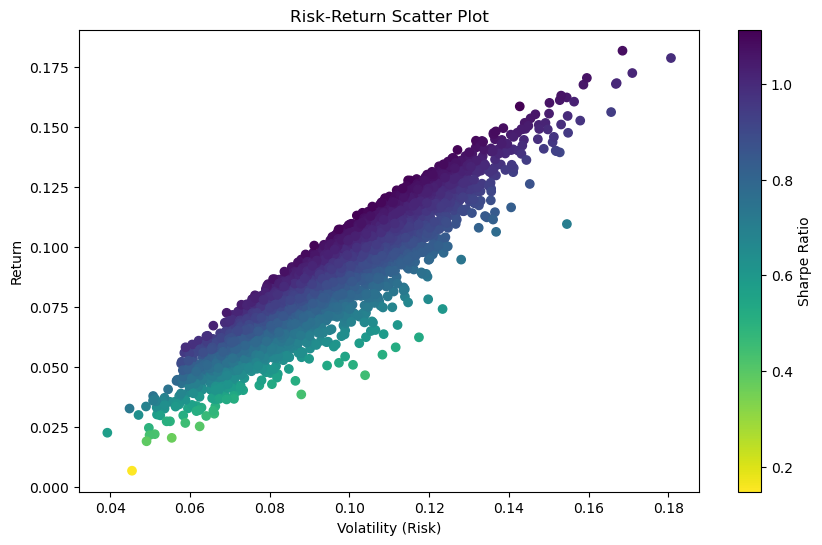

In [61]:
# Plot the risk/return scatter plot of all the 5,000 portfolios
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis_r')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.title('Risk-Return Scatter Plot')
plt.show()

The scatter plot provides a visual representation of the risk-return profile for 5,000 randomly generated portfolios from the Monte Carlo simulation. It demonstrates a clear upward trend, where higher portfolio risk (measured by volatility) corresponds to higher expected returns. This pattern aligns with the fundamental finance principle that increased returns are typically associated with greater risk.

The color gradient, ranging from yellow to dark purple, represents the Sharpe ratios of the portfolios, with darker colors indicating higher Sharpe ratios (better risk-adjusted returns). The most optimal portfolios, characterized by higher Sharpe ratios, are clustered in the upper-left portion of the plot, reflecting portfolios that achieve relatively high returns with moderate risk. Conversely, portfolios in lighter colors (yellow and green) tend to have lower Sharpe ratios, offering lower risk-adjusted returns.

Overall, the plot highlights the impact of diversification, with portfolios on the lower-left showing lower volatility but also lower returns, representing more conservative allocations. As we move toward the upper-right, we encounter more aggressive portfolios with higher risk and return profiles, showing a wide range of potential outcomes based on different portfolio weightings.

## Question 13

In this block of code, the goal is to identify and highlight the portfolio with the minimum volatility (risk) among the 5,000 randomly generated portfolios, and then plot it on the risk-return scatter plot.

First, the index of the portfolio with the minimum volatility is found using np.argmin(results[1, :]), which returns the index of the lowest value in the volatility (risk) array. This portfolio represents the one with the least amount of risk among all portfolios.

The code then creates a scatter plot similar to the one generated in the previous block, where each portfolio is plotted with its volatility on the x-axis and its return on the y-axis, with the color representing the Sharpe ratio. The color map and labels remain the same as before, providing context for the portfolio performance.

After plotting all portfolios, the portfolio with the minimum volatility is highlighted using a blue star marker ('*') of size 100. This visually distinguishes the minimum volatility portfolio on the plot, allowing the user to easily identify it. The plot includes labels for the axes and a legend to indicate the minimum volatility portfolio.

Finally, the plt.show() function displays the plot, showing the minimum volatility portfolio in relation to the other portfolios generated in the Monte Carlo simulation. This helps in analyzing how the minimum volatility portfolio compares to other portfolios in terms of return and Sharpe ratio.

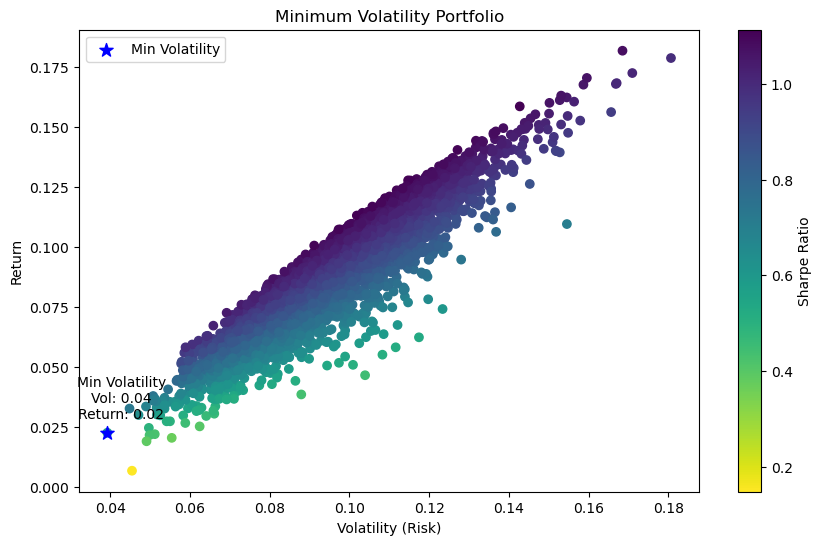

In [65]:
# Get the index of the portfolio with the minimum volatility
min_vol_idx = np.argmin(results[1, :])

# Plot with stars for min-vol and max-Sharpe portfolios
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis_r')
plt.colorbar(label='Sharpe Ratio')

# Min volatility portfolio
plt.scatter(results[1, min_vol_idx], results[0, min_vol_idx], color='blue', marker='*', s=100, label='Min Volatility')

# Annotate the min volatility portfolio with the exact values
plt.annotate(f'Min Volatility\nVol: {results[1, min_vol_idx]:.2f}\nReturn: {results[0, min_vol_idx]:.2f}', 
             (results[1, min_vol_idx], results[0, min_vol_idx]), 
             textcoords="offset points", 
             xytext=(10, 10), 
             ha='center', color='black')

plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.legend()
plt.title('Minimum Volatility Portfolio')
plt.show()

The scatter plot focuses on the Minimum Volatility Portfolio, marked by the blue star, which represents the portfolio with the least risk (volatility) among the 5,000 portfolios generated in the Monte Carlo simulation. This portfolio, located in the lower-left section of the chart, achieves a return close to 0.025 with very low volatility, approximately 0.04. While this portfolio minimizes risk, the trade-off is a relatively lower return compared to higher-volatility portfolios further to the right. The plot shows that the minimum volatility portfolio provides stability but at the cost of potentially higher returns, which is a key consideration for risk-averse investors seeking to minimize risk while maintaining a modest return. This portfolio is ideal for conservative investors prioritizing low-risk investments.

## Question 14

In this block of code, the goal is to identify and highlight the portfolio with the maximum Sharpe ratio (the best risk-adjusted return) among the 5,000 portfolios and plot it on the risk-return scatter plot.

The index of the portfolio with the highest Sharpe ratio is found using np.argmax(results[2, :]), which returns the index of the highest value in the Sharpe ratio array. This portfolio represents the one with the best risk-adjusted return.

The scatter plot is generated again, similar to previous blocks, where the portfolios are plotted with volatility on the x-axis and return on the y-axis, with the color representing the Sharpe ratio. The color map and labels remain consistent for clarity.

After plotting all the portfolios, the portfolio with the highest Sharpe ratio is highlighted using a red star marker ('*') of size 100. This allows for easy identification of the maximum Sharpe ratio portfolio on the chart. The plot also includes labels for the axes and a legend to indicate the portfolio with the highest Sharpe ratio.

Finally, the plt.show() function displays the scatter plot with the highlighted maximum Sharpe portfolio, enabling the user to analyze how this portfolio compares to others in terms of risk and return. This visualization helps in identifying the best-performing portfolio from a risk-adjusted return perspective.

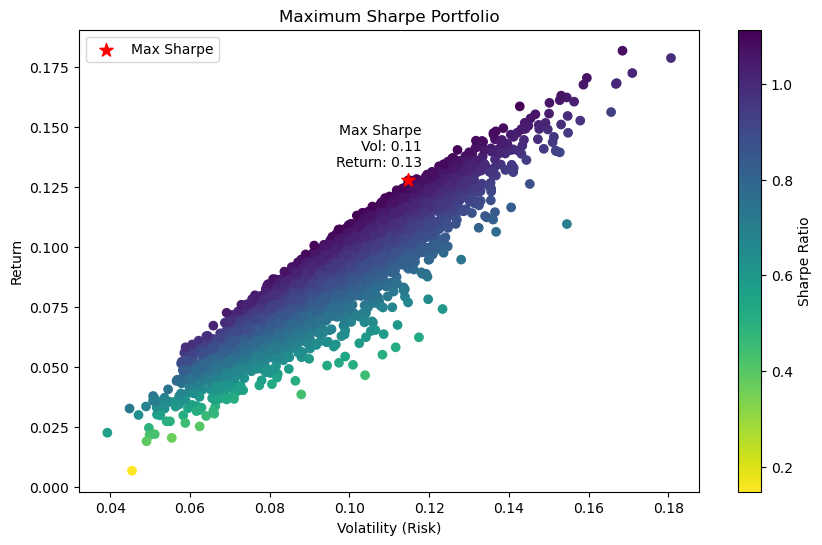

In [69]:
# Get the index of the portfolio with the maximum Sharpe ratio
max_sharpe_idx = np.argmax(results[2, :])

# Plot with stars for min-vol and max-Sharpe portfolios
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis_r')
plt.colorbar(label='Sharpe Ratio')

# Max Sharpe portfolio
plt.scatter(results[1, max_sharpe_idx], results[0, max_sharpe_idx], color='red', marker='*', s=100, label='Max Sharpe')

# Annotate the max Sharpe portfolio with the exact values
plt.annotate(f'Max Sharpe\nVol: {results[1, max_sharpe_idx]:.2f}\nReturn: {results[0, max_sharpe_idx]:.2f}', 
             (results[1, max_sharpe_idx], results[0, max_sharpe_idx]), 
             textcoords="offset points", 
             xytext=(10, 10), 
             ha='right', color='black')

plt.xlabel('Volatility (Risk)')
plt.ylabel('Return')
plt.legend()
plt.title('Maximum Sharpe Portfolio')
plt.show()


This scatter plot focuses on the Maximum Sharpe Ratio Portfolio, represented by the red star. The Sharpe ratio measures the risk-adjusted return, and this specific portfolio has the highest Sharpe ratio among the 5,000 portfolios generated in the Monte Carlo simulation. It is positioned near the upper-left section of the plot, indicating a portfolio with relatively high return and moderate volatility (risk), offering the best balance between risk and reward.

In comparison to other portfolios in the scatter plot, the maximum Sharpe portfolio achieves a higher return without taking on excessive volatility. This portfolio is ideal for investors seeking the best risk-adjusted performance, as it provides the most efficient combination of risk and return in the simulation. The visualization highlights how this portfolio stands out from others by achieving a higher return per unit of risk, making it an optimal choice for maximizing investment performance.

## Question 15

In this block of code, the Sharpe ratios of the equal-weighted portfolio and the maximum Sharpe ratio portfolio are compared.

The code prints the Sharpe ratio of the equal-weighted portfolio, stored in the variable portfolio_sharpe, which was calculated earlier. It also retrieves and prints the Sharpe ratio of the portfolio with the highest Sharpe ratio from the Monte Carlo simulation, using the index max_sharpe_idx found in the previous block.

This comparison allows you to see whether the equal-weighted portfolio performs better or worse than the portfolio with the maximum Sharpe ratio. The goal is to determine whether the equal-weighted portfolio provides a competitive risk-adjusted return compared to the best possible portfolio from the simulation.

In [73]:
# equal_weight_sharpe = results[2, np.argmin(np.abs(weights_record.mean(axis=0) - 1/len(annual_returns)))]
print(f"Equal Weight Portfolio Sharpe: {portfolio_sharpe:.4f}")
print(f"Max Sharpe Portfolio Sharpe: {results[2, max_sharpe_idx]:.4f}")

Equal Weight Portfolio Sharpe: 1.0077
Max Sharpe Portfolio Sharpe: 1.1139


## Question 16

n this block of code, the daily returns for the maximum Sharpe portfolio are calculated by multiplying the strategy returns by their corresponding optimal weights, retrieved from the weights_record DataFrame. The result is a new column, Max_Sharpe_Portfolio, which represents the combined returns of the strategies using the weight distribution that resulted in the highest Sharpe ratio during the Monte Carlo simulation.

To further analyze the portfolio, a function calculate_performance_stats is defined. This function calculates:

- **Annualized Mean Return:** The mean return of the portfolio scaled by the number of trading days in a year (260).
- **Annualized Volatility:** The standard deviation of the daily returns, scaled by the square root of 260 to annualize it.
- **Sharpe Ratio:** The ratio of the annualized return to the annualized volatility, providing a measure of risk-adjusted return assuming a risk-free rate of zero.

Finally, the performance statistics for the updated myStrategies_df DataFrame, which includes the maximum Sharpe portfolio, are computed and displayed. This provides key metrics to evaluate the portfolio's effectiveness in terms of return and risk.

In [76]:
weights_record.iloc[max_sharpe_idx]

AAPL-MAFlat     0.197199
AMZN-MAFlat     0.207496
AUD-BB          0.150408
FBNDX-BMK-MA    0.128283
GE-MAShort      0.132035
GOLD-MAShort    0.173086
INTC-BB         0.006386
SPY-MAFlat      0.005106
Name: 255, dtype: float64

In [77]:
# Function to calculate performance statistics
def calculate_performance_stats(df):
    performance_stats = {}
    performance_stats['Mean Return'] = df.mean() * 260  # Annualized mean returns
    performance_stats['Volatility'] = df.std() * np.sqrt(260)  # Annualized volatility
    performance_stats['Sharpe Ratio'] = performance_stats['Mean Return'] / performance_stats['Volatility']
    return pd.DataFrame(performance_stats)

In [78]:
# Original weights of the maximum Sharpe portfolio
weights_max_sharpe = np.array([0.197199, 0.207496, 0.150408, 0.128283, 
                               0.132035, 0.173086, 0.006386, 0.005106])

In [79]:
# Calculate daily returns for the maximum Sharpe portfolio using only the original strategies
max_sharpe_daily_returns = (myStrategies_df * weights_max_sharpe).sum(axis=1)

In [80]:
# Create a copy of myStrategies_df before modifying
myStrategies_df = myStrategies_df.copy()

# Add the maximum Sharpe portfolio returns as a new column
myStrategies_df['Max_Sharpe_Portfolio'] = max_sharpe_daily_returns

In [81]:
# Calculate the performance statistics for the updated DataFrame
performance_statistics = calculate_performance_stats(myStrategies_df)

# Display the performance statistics
print(performance_statistics)

                      Mean Return  Volatility  Sharpe Ratio
AAPL-MAFlat              0.222849    0.296838      0.750743
AMZN-MAFlat              0.260893    0.330598      0.789155
AUD-BB                  -0.000278    0.057321     -0.004843
FBNDX-BMK-MA             0.003581    0.038143      0.093893
GE-MAShort               0.128027    0.308737      0.414681
GOLD-MAShort             0.071038    0.179685      0.395347
INTC-BB                 -0.031812    0.113463     -0.280369
SPY-MAFlat               0.056340    0.117781      0.478349
Max_Sharpe_Portfolio     0.127782    0.114715      1.113906


## Question 17:

This block of code calculates the beta of the Maximum Sharpe Portfolio in relation to the S&P 500 (SPY) returns through a regression analysis. Beta measures the portfolio's volatility relative to the market, indicating its sensitivity to market movements. First, the code extracts the SPY returns as the dependent variable and the SPY benchmark returns (SPY-BMK-MA) as the independent variable. It filters the benchmark returns to include only positive values, focusing on upward market movements, and then calculates the log returns for these values to stabilize potential volatility.

Next, the stock returns and independent variable are aligned by removing any NaN or infinite values, ensuring the data is clean for regression. A constant is added to account for the intercept in the regression model. Using the statsmodels library, an Ordinary Least Squares (OLS) regression is performed, regressing the stock returns on the benchmark returns. The beta value, which measures the portfolio's sensitivity to the market, is extracted from the model’s parameters.

The interpretation of beta is straightforward: if β > 1, the portfolio is more volatile than the market, indicating potential for higher returns but greater risk. If β < 1, the portfolio is less volatile, offering more stability but potentially lower returns. If β = 1, the portfolio moves in line with the market, implying similar risk and return characteristics. The code also prints the regression summary and the computed beta value for further analysis.

In [84]:
spy_benchmark_returns = master_df['SPY-BMK-MA'].dropna()  # SPY benchmark returns
covariance = np.cov(myStrategies_df['Max_Sharpe_Portfolio'].dropna(), spy_benchmark_returns)[0, 1]
beta = covariance / spy_benchmark_returns.var()
print(f"Beta of Max Sharpe Portfolio: {beta}")

Beta of Max Sharpe Portfolio: 0.18483836182077545


## Question 18:

This block of code defines a function to calculate the Sharpe ratio for a given portfolio, which is a measure of risk-adjusted return. The function computes the annualized return and volatility of the portfolio based on the mean and standard deviation of the portfolio’s daily returns, assuming 260 trading days in a year. The Sharpe ratio is calculated by dividing the annualized return by the annualized volatility.

The code then constructs four different equal-weighted portfolios, each based on a specific strategy:

BMK-only Portfolio: This portfolio uses the base benchmark returns (BMK-MA) for each instrument, and its returns are the average of the benchmark returns across all instruments. The Sharpe ratio is calculated for this portfolio.

MAFlat Strategy Portfolio: This portfolio uses the Moving Average Flat (MAFlat) strategy across all instruments. The average of the MAFlat returns for each instrument is calculated to get the portfolio's returns, and its Sharpe ratio is then computed.

MAShort Strategy Portfolio: This portfolio uses the Moving Average Short (MAShort) strategy for all instruments. Like the previous portfolios, the average of the MAShort returns is used to compute the portfolio's returns, and its Sharpe ratio is determined.

BollingerBand Strategy Portfolio: This portfolio applies the Bollinger Bands strategy across all instruments, and its returns are calculated as the average of the Bollinger Bands returns. The Sharpe ratio for this portfolio is then calculated.

Next, the Sharpe ratio for the Max Sharpe Portfolio is computed using the max_sharpe_daily_returns from previous calculations.

Finally, the code compares the Sharpe ratios of the four constructed portfolios (BMK-only, MAFlat, MAShort, and BollingerBand) with the Max Sharpe Portfolio. It checks whether each portfolio outperforms the Max Sharpe Portfolio based on their respective Sharpe ratios. The results are printed, indicating which portfolios outperform the Max Sharpe Portfolio in terms of risk-adjusted return.

In [87]:
# Define a function to calculate the Sharpe ratio for a given portfolio
def calculate_portfolio_sharpe(portfolio_returns):
    # Calculate annualized return and volatility
    annualized_return = portfolio_returns.mean() * 260  # Assuming 260 trading days in a year
    annualized_volatility = portfolio_returns.std() * np.sqrt(260)  # Annualized volatility
    sharpe_ratio = annualized_return / annualized_volatility  # Sharpe ratio
    return sharpe_ratio

# (a) BMK-only Portfolio (using base instruments)
bmk_columns = [f'{instrument}-BMK-MA' for instrument in selected_instruments]
bmk_only_returns = master_df[bmk_columns].mean(axis=1)  # Equal-weighted portfolio
bmk_sharpe = calculate_portfolio_sharpe(bmk_only_returns)

# (b) MAFlat Strategy Portfolio
maflat_columns = [f'{instrument}-MAFlat' for instrument in selected_instruments]
maflat_returns = master_df[maflat_columns].mean(axis=1)  # Equal-weighted portfolio
maflat_sharpe = calculate_portfolio_sharpe(maflat_returns)

# (c) MAShort Strategy Portfolio
mashort_columns = [f'{instrument}-MAShort' for instrument in selected_instruments]
mashort_returns = master_df[mashort_columns].mean(axis=1)  # Equal-weighted portfolio
mashort_sharpe = calculate_portfolio_sharpe(mashort_returns)

# (d) BollingerBand Strategy Portfolio
bollinger_columns = [f'{instrument}-BB' for instrument in selected_instruments]
bollinger_returns = master_df[bollinger_columns].mean(axis=1)  # Equal-weighted portfolio
bollinger_sharpe = calculate_portfolio_sharpe(bollinger_returns)

# Step 5: Compare with Max Sharpe Portfolio
# Calculate the Sharpe ratio for the Max Sharpe Portfolio
max_sharpe_returns = max_sharpe_daily_returns
# Assuming this variable is already defined
max_sharpe_ratio = calculate_portfolio_sharpe(max_sharpe_returns)

# Display the Sharpe ratios for all 4 portfolios
print(f"Sharpe Ratio for BMK-only Portfolio: {bmk_sharpe:.4f}")
print(f"Sharpe Ratio for MAFlat Strategy Portfolio: {maflat_sharpe:.4f}")
print(f"Sharpe Ratio for MAShort Strategy Portfolio: {mashort_sharpe:.4f}")
print(f"Sharpe Ratio for BollingerBand Strategy Portfolio: {bollinger_sharpe:.4f}")
print(f"Sharpe Ratio for Max Sharpe Portfolio: {max_sharpe_ratio:.4f}")

# Check which portfolios outperform the Max Sharpe Portfolio
outperforming_portfolios = {
    'BMK-only': bmk_sharpe > max_sharpe_ratio,
    'MAFlat': maflat_sharpe > max_sharpe_ratio,
    'MAShort': mashort_sharpe > max_sharpe_ratio,
    'BollingerBand': bollinger_sharpe > max_sharpe_ratio
}

# Print outperforming portfolios
for portfolio, outperforms in outperforming_portfolios.items():
    if outperforms:
        print(f"{portfolio} Portfolio outperforms the Max Sharpe Portfolio.")
    else:
        print(f"{portfolio} Portfolio does not outperform the Max Sharpe Portfolio.")

Sharpe Ratio for BMK-only Portfolio: 0.4484
Sharpe Ratio for MAFlat Strategy Portfolio: 0.8086
Sharpe Ratio for MAShort Strategy Portfolio: 0.6099
Sharpe Ratio for BollingerBand Strategy Portfolio: 0.0558
Sharpe Ratio for Max Sharpe Portfolio: 1.1139
BMK-only Portfolio does not outperform the Max Sharpe Portfolio.
MAFlat Portfolio does not outperform the Max Sharpe Portfolio.
MAShort Portfolio does not outperform the Max Sharpe Portfolio.
BollingerBand Portfolio does not outperform the Max Sharpe Portfolio.
